In [1]:
# First install spacy and the transformer model - If you are using CUDA and cuDNN you may have to make symlinks of the libraries in order to comply with the requirements of the transformer model
#!pip install spacy==3.7.0
#!pip install spacy-transformers
#!python3 -m spacy download es_dep_news_trf

# Film reviews Text Classification
## Introduction

In this notebook, we are working on a text classification problem using a dataset of film reviews. The goal is to predict a punctuation similar to the one the review has.

#### Declare dependencies

In [2]:
import os
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try: 
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


I0000 00:00:1728567844.506356   22748 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728567844.786210   22748 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728567844.786794   22748 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728567844.792316   22748 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728567844.792808   22748 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [3]:

import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, GRU
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.utils import to_categorical
import re
from tensorflow.keras.callbacks import ModelCheckpoint
import spacy
from keras.optimizers import Adam
import spacy_transformers
import numpy as np 



#### Load DataFrame

In [4]:
film_df = pd.read_csv('film_reviews_result.csv', sep='|', encoding='utf-8')
film_df.head()

,film_name,gender,film_avg_rate,review_rate,review_title,review_text
0,Respira (Serie de TV),"Serie de TV, Drama, Medicina","4,6",1,Respira,"Como fan de las series españolas y de Najwa, e..."
1,Respira (Serie de TV),"Serie de TV, Drama, Medicina","4,6",2,Esta serie te llama tonto a la cara,Todo lo malo que puede tener una serie lo pose...
2,Respira (Serie de TV),"Serie de TV, Drama, Medicina","4,6",1,Respira,"La serie es un drama médico que intenta ""copia..."
3,Respira (Serie de TV),"Serie de TV, Drama, Medicina","4,6",1,"Imposible, no hay manera",Nadie te obliga a ver nada que no quieras ver ...
4,Respira (Serie de TV),"Serie de TV, Drama, Medicina","4,6",1,Serie nefasta,Está serie da vergüenza ajena. Una serie donde...


#### Check labels (Our categories to classify)

In [5]:
distinct_labels = film_df['review_rate'].unique()
print(distinct_labels)

[ 1  2  5  3  6  4  7  8  9 10]


#### Tokenize the text

In [6]:
# Convert text data to strings to avoid AttributeError
film_df['review_text'] = film_df['review_text'].astype(str)
film_df['review_title'] = film_df['review_title'].astype(str)
film_df['film_name'] = film_df['film_name'].astype(str)
film_df['gender'] = film_df['gender'].astype(str)
# Concatenate the text columns
film_df['combined_text'] = film_df['review_title'] + ' ' + film_df['review_text'] + ' ' + film_df['gender']+ ' ' + film_df['film_name']

# Replace Spanish letters with their base letters
film_df['combined_text'] = film_df['combined_text'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
film_df['combined_text'].head()

0    Respira Como fan de las series espanolas y de ...
1    Esta serie te llama tonto a la cara Todo lo ma...
2    Respira La serie es un drama medico que intent...
3    Imposible, no hay manera Nadie te obliga a ver...
4    Serie nefasta Esta serie da verguenza ajena. U...
Name: combined_text, dtype: object

### Lemmatizer definition
We will use the es_dep_news_trf model from spacy.

In [7]:
nlp = spacy.load('es_dep_news_trf')

def lemmatizer(text):  
  doc = nlp(text)
  return ' '.join([word.lemma_ for word in doc])

#### Lemmatizing combined_text

In [8]:
# Apply the Spanish stemmer to all the words in the 'combined_text' column
film_df['combined_text'] = film_df['combined_text'].apply(lambda x: lemmatizer(x))
# Print the first 5 rows to verify
print(film_df['combined_text'].head())


0    Respira Como fan de el serie espanola y de Naj...
1    este serie tú llamar tonto a el cara todo él m...
2    Respira el serie ser uno drama medico que inte...
3    imposible , no haber manera nadie tú obligar a...
4    serie nefasto este serie dar verguenza ajeno ....
Name: combined_text, dtype: object


##### Tokenizing words

In [9]:
# Initialize the tokenizer with a custom filter to remove special characters
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')

# Fit the tokenizer on the text data
tokenizer.fit_on_texts(film_df['combined_text'])

# Convert the text to sequences
sequences = tokenizer.texts_to_sequences(film_df['combined_text'])

# Print the first 5 sequences to verify
print(sequences[:5])

# Get the maximum length of the sequences
max_len_combined_text = max(len(seq) for seq in sequences)
print(f'Max length of combined_text: {max_len_combined_text}')

[[6346, 20, 393, 2, 1, 16, 738, 6, 2, 5416, 17, 2389, 1, 16, 8, 21, 118, 11209, 12039, 46, 22, 4, 3, 46, 1336, 5880, 5416, 30, 2, 118, 125, 3505, 3, 10, 289, 296, 1875, 103, 1432, 2, 18144, 11, 5, 83, 788, 6, 277, 209, 7, 258, 509, 20, 253, 1110, 64, 67, 3, 674, 4, 202, 2, 1379, 7570, 2, 216, 16, 2, 32, 45, 1975, 6346, 16, 2, 32], [17, 16, 40, 426, 936, 9, 1, 446, 24, 4, 118, 3, 36, 27, 5, 16, 4, 1275, 6346, 1, 277, 8, 3957, 1, 35, 8, 514, 2686, 1, 80, 4, 29, 254, 2, 556, 6, 1, 97, 145, 1, 279, 446, 2, 110, 296, 2, 1, 156, 95, 6196, 6, 240, 1, 4095, 3, 516, 6, 22, 158, 4640, 18145, 3, 30, 1976, 128, 7, 17, 155, 64, 28, 29, 1, 126, 79, 2, 1, 629, 13011, 6, 10, 8, 14, 980, 23, 43, 9, 30, 4, 33, 64, 8, 5, 16, 1111, 3, 10, 254, 9, 720, 1, 102, 23, 8, 3, 10, 15, 3754, 413, 2, 2611, 7, 266, 194, 128, 10, 15, 59, 697, 8, 514, 988, 495, 3348, 24, 38, 1363, 95, 5881, 3, 4, 8, 6, 13, 3, 525, 27, 1, 3818, 96, 9, 24, 13, 15, 175, 8553, 29, 6346, 13, 15, 175, 13012, 936, 2, 4371, 16, 2, 32, 45, 197

#### Getting max_len and max_token for the model

In [10]:
# Get the maximum length of the sequences
max_len_combined_text = max(len(seq) for seq in sequences)
print(f'Max length of combined_text: {max_len_combined_text}')

max_token_value = max(max(seq) for seq in sequences if seq)
print(f'Max token value in sequences: {max_token_value}')

Max length of combined_text: 1122
Max token value in sequences: 49434


#### Getting the review rates for the model

In [11]:
reviews_rates = film_df['review_rate'].to_numpy()
reviews_rates[:5]

array([1, 2, 1, 1, 1])

#### Train test split the sequences and labels

In [12]:
# Split the sequences and label_encoded into training and testing sets
# Split the sequences and label_encoded into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(sequences, reviews_rates, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

# Print the shapes of the resulting arrays to verify
print(f'X_train shape: {len(X_train)}')
print(f'X_val shape: {len(X_val)}')
print(f'X_test shape: {len(X_test)}')
print(f'y_train shape: {len(y_train)}')
print(f'y_val shape: {len(y_val)}')
print(f'y_test shape: {len(y_test)}')

X_train shape: 7040
X_val shape: 2414
X_test shape: 604
y_train shape: 7040
y_val shape: 2414
y_test shape: 604


#### Define Max words and Max Length

In [13]:
# Define the maximum number of words and the maximum sequence length
max_words = max_token_value
max_len = max_len_combined_text

#### Adapt Sequences and labels

In [14]:
# Pad the sequences to ensure uniform input size (this put a 0 in front of the sequence to make them all the same length)
X_train_padded = pad_sequences(X_train, maxlen=max_len)
X_test_padded = pad_sequences(X_test, maxlen=max_len)
X_val_padded = pad_sequences(X_val, maxlen=max_len)

# Convert labels to categorical format (this change the label to a one-hot encoded format e.g [0,0,1,0])
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)
y_val_categorical = to_categorical(y_val)

In [15]:
# Replace commas with dots in the 'film_avg_rate' column
film_df['film_avg_rate'] = film_df['film_avg_rate'].str.replace(',', '.').astype(float)


# Verify the conversion
print(film_df['film_avg_rate'].head())

0    4.6
1    4.6
2    4.6
3    4.6
4    4.6
Name: film_avg_rate, dtype: float64


In [16]:
# Normalize the film_avg_rate feature
film_df['film_avg_rate'] = (film_df['film_avg_rate'] - film_df['film_avg_rate'].mean()) / film_df['film_avg_rate'].std()


# Add the normalized film_avg_rate to the padded sequences
X_train_combined = [np.append(seq, film_df.loc[idx, 'film_avg_rate']) for idx, seq in enumerate(X_train_padded)]
X_val_combined = [np.append(seq, film_df.loc[idx, 'film_avg_rate']) for idx, seq in enumerate(X_val_padded)]
X_test_combined = [np.append(seq, film_df.loc[idx, 'film_avg_rate']) for idx, seq in enumerate(X_test_padded)]

X_train_combined = np.array(X_train_combined)
X_val_combined = np.array(X_val_combined)
X_test_combined = np.array(X_test_combined)

### Model
#### Defining and Fitting

In [17]:
checkpoint = ModelCheckpoint('best_model.weights.h5', monitor='val_accuracy', save_best_only=True, mode='max', save_weights_only=True)

# Adjust the model to accept the additional input feature
model = Sequential()
model.add(Embedding(max_words, 100, input_length=max_len + 1))  # +1 for the additional feature
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2))
model.add(Dense(y_train_categorical.shape[1], activation='softmax'))  # Ensure the output layer matches the number of unique labels

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

model.build((None, max_len + 1))
# Print the model summary
model.summary()

# Train the model
history = model.fit(X_train_combined, y_train_categorical, epochs=30, batch_size=64, validation_data=(X_val_combined, y_val_categorical), callbacks=[checkpoint])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 1123, 100)      │     4,943,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 1123, 100)      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 11)             │         1,111 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,024,911 (19.17 MB)

 Trainable params: 5,024,911 (19.17 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 15s 116ms/step - accuracy: 0.1577 - loss: 2.2886 - val_accuracy: 0.1686 - val_loss: 2.2100
Epoch 2/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 11s 98ms/step - accuracy: 0.1841 - loss: 2.1557 - val_accuracy: 0.2229 - val_loss: 2.0483
Epoch 3/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/step - accuracy: 0.2783 - loss: 1.8776 - val_accuracy: 0.2486 - val_loss: 1.9914
Epoch 4/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 18s 73ms/step - accuracy: 0.3617 - loss: 1.6523 - val_accuracy: 0.2510 - val_loss: 1.9530
Epoch 5/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - accuracy: 0.4275 - loss: 1.4745 - val_accuracy: 0.2668 - val_loss: 2.0341
Epoch 6/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 11s 100ms/step - accuracy: 0.5027 - loss: 1.2604 - val_accuracy: 0.2494 - val_loss: 2.1604
Epoch 7/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - accuracy: 0.5638 - loss: 1.1487 - val_accuracy: 0.2697 - val_loss: 2.2891
Epoch 8/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.6524 - loss: 0.934

In [18]:
model.load_weights('best_model.weights.h5')

#### Testing Accuracy on test data

In [19]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test_combined, y_test_categorical, verbose=0)

print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

Test Loss: 2.9595224857330322
Test Accuracy: 0.23675496876239777


#### Plot a graph to show loss and accuracy over each epoch of the model

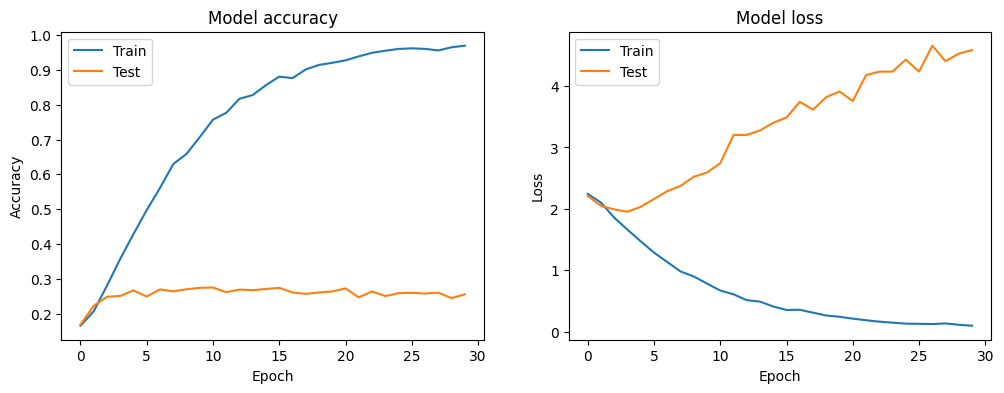

In [20]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

#### Predict one test data only

In [21]:
# Select a single test sample
sample_index = 5
sample = X_test_combined[sample_index].reshape(1, -1)

# Predict the label for the sample
predicted_probabilities = model.predict(sample)
predicted_label = predicted_probabilities.argmax(axis=-1)
real_label = y_test[sample_index]

# Decode the predicted label to its original category
print(f'Predicted review rate: {predicted_label[0]}')
print(f'Real review rate: {real_label}')

1/1 ━━━━━━━━━━━━━━━━━━━━ -2s -1661283us/step
Predicted review rate: 7
Real review rate: 10


#### Predict all test data

In [22]:
# Predict the labels for all samples in X_test_padded
predicted_probabilities_all = model.predict(X_test_combined)
predicted_labels_all = predicted_probabilities_all.argmax(axis=-1)

# Print the first 10 predictions to verify
for i in range(10):
    print(f'Sample {i}: Predicted review rate: {predicted_labels_all[i]}, Real review rate: {y_test[i]}')

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
Sample 0: Predicted review rate: 6, Real review rate: 6
Sample 1: Predicted review rate: 8, Real review rate: 8
Sample 2: Predicted review rate: 6, Real review rate: 2
Sample 3: Predicted review rate: 7, Real review rate: 3
Sample 4: Predicted review rate: 6, Real review rate: 6
Sample 5: Predicted review rate: 7, Real review rate: 10
Sample 6: Predicted review rate: 8, Real review rate: 8
Sample 7: Predicted review rate: 7, Real review rate: 7
Sample 8: Predicted review rate: 6, Real review rate: 5
Sample 9: Predicted review rate: 7, Real review rate: 7


#### Plot test reviews versus predictions

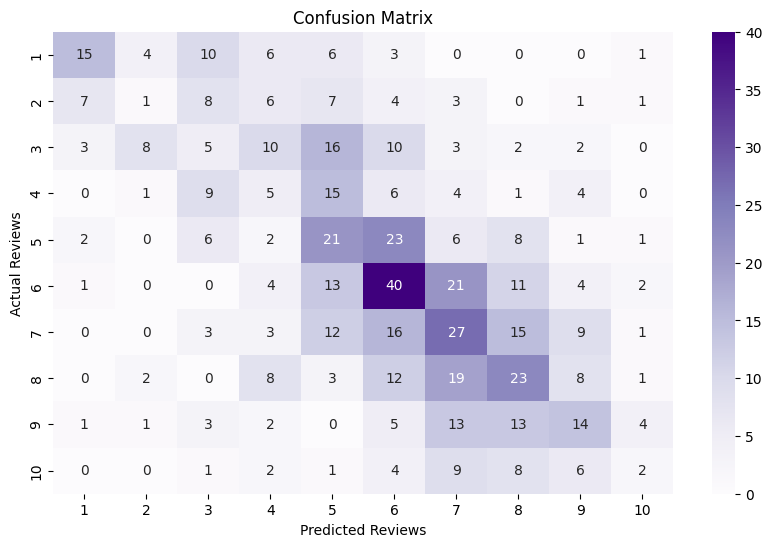

In [23]:
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_labels_all)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples', xticklabels=[1,2,3,4,5,6,7,8,9,10], yticklabels=[1,2,3,4,5,6,7,8,9,10])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Reviews')
plt.ylabel('Actual Reviews')
plt.show()


## Conclusion

In this notebook, we successfully built a model for text classification that try to guess what was the rate using the review text... Even though it is not perfect, we can see in the last graph that the model in general approachs to the target label and there are very few cases where the model is really off the real review rate. Being this said, the model could be improved using Spacy (V. 3.7 doesn't break Tensorflow, the other one does because of numpy) and lemmatizing the words. We could also train the model for more epochs and tune it to make better predictions.
